## Demo of each step of the aggregation pipeline


In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import sys
sys.path.append('../src')

from utils import Config, DataProcessor, Network, find_matching_folder
from models import SpatialAggregation, TemporalAggregation
from visuals import Visualization

In [39]:
config = Config(year = 2013,
                demand = "k-interpolation",
                k_neighbors_CF = 3,
                k_weight_demand = 3,
                time_scale="weekly",
                n_repr=5,
                k_representative_days=5,
                weights={
                    'position': 1.0,
                    'time_series': 1.0,
                    'duration_curves': 1.0,
                    'rdc': 1.0,
                    'intra_correlation': 1.0,
                    'inter_correlation': 1.0,
                    'supply_demand_mismatch': 1.0
                })
                
config.explain_config()
print(f"\nCurrent config:\n{config}")

year: The year considered for the capacity factors and the demand time series.
demand: The method used to calculate the demand mismatch. Options are 'total_demand' (compare supply at each node to the total demand) or 'k-interpolation' (compare supply to a weighted sum of the demand, considering k number of points).
k_weight_demand: The number of nearest demand points considered for the weighted sum of the demand when using 'k-interpolation'. Must be a positive integer and less than or equal to the total number of demand points.
time_scale: The time scale used for the supply-demand mismatch calculation. Options are 'yearly' (a single correlation number for the whole year), 'monthly' (correlation calculated for each month), or 'weekly' (correlation calculated for each week).
k_neighbors_CF: The number of nearest nodes considered for the linear interpolation of capacity factor nodes to match the network nodes. If k=1, only the nearest node is considered. If k equals the number of CF nodes

In [4]:
nodes_df, demand_df, wind_df, solar_df, wind_CF, solar_CF = DataProcessor.import_and_interpolate_data(config)

Number of duplicates deleted in nodes_df: 2238


In [5]:
TimeSeries = {'wind': wind_df, 'solar': solar_df};

In [6]:
network = Network(nodes_df, demand_df, TimeSeries, config, time_horizon=None)

The 'features' dictionary has been created and can be accessed as '.features'
It is a dictionary with keys for each node in range(0, 2605).
Each value is a dictionary with the features of that node.

Example structure:
network.features[0].keys() = dict_keys(['position', 'time_series', 'duration_curves', 'ramp_duration_curves', 'correlation', 'supply_demand_mismatch'])

Details:
  - Position: A tuple (latitude, longitude) of that node.
  - Time series: A dictionary with keys for each time series type in dict_keys(['wind', 'solar'])
    and values as the time series itself.
  - Duration Curves: A dictionary with keys for each time series type in dict_keys(['wind', 'solar'])
    and values as the duration curve of the time series.
  - Ramp Duration Curves (RDCs): A dictionary with keys for each time series type dict_keys(['wind', 'solar'])
    and values as the RDC (found by differentiating and subsequently sorting) of the time series.
  - Correlation: A dictionary with keys as tuples of 

In [7]:
aggregator = SpatialAggregation(network.features, config)

In [32]:
# Do you want to load a distance matrix or do you want to compute it? (yes/no)
# /!\ Computing a distance matrix can take a long time (up to 1h)
# /!\ If you have already computed a distance matrix for a specific configuration, you can load it
load_distance_matrix = "yes"

# /!\ If you want to load a distance matrix, do you know the folder name? (yes/no)
# /!\ If you don't know the folder name, the script will find the folder with the matching configuration, you only have to provide the configuration you want to load
do_you_know_the_folder = "no"
folder_name = None # If you know the folder name, you can write it here as a str

# If you don't know the folder name, provide the configuration you want to load
config_to_match = config
time_series = list(TimeSeries.keys())

# Do not change the following lines
if load_distance_matrix == "no":
    aggregator.set_distance_metrics()
elif load_distance_matrix == "yes":
    if do_you_know_the_folder == "yes":
        aggregator.set_distance_metrics(dir_distance_metrics = folder_name)
    elif do_you_know_the_folder == "no":
        folder_name = find_matching_folder(config_to_match, time_series)
        if folder_name is None:
            print("No folder found with the matching configuration")
            sys.exit()
        aggregator.set_distance_metrics(dir_distance_metrics = folder_name)

Searching for a folder with the following configuraton:
year: 2013, 
demand: k-interpolation, 
k_neighbors_CF: 3, 
k_weight_demand: 3, 
time_scale: weekly, 
drop_duplicates: True,
time series: ['solar', 'wind']
...
Metadata file not found in '2025-03-24 22h20 - Distance Metrics'
Metadata file not found in '2025-03-24 22h23 - Distance Metrics'
Found matching folder: '2025-03-25 00h09 - Distance Metrics'


In [33]:
print(aggregator.distance_metrics.keys())

dict_keys(['duration_curves_distance', 'inter_correlation_distance', 'intra_correlation_distance', 'position_distance', 'rdc_distance', 'supply_demand_mismatch_distance', 'time_series_distance'])


In [10]:
#optimized_assignment_dict = aggregator.optimize()

In [11]:
config.weights = {
        'position': 3.0,
        'time_series': 1.0,
        'duration_curves': 1.0,
        'rdc': 1.0,
        'intra_correlation': 1.0,
        'inter_correlation': 1.0,
        'supply_demand_mismatch': 1.0
    }
cluster_assignment_dict = aggregator.cluster_KMedoids()

Clustering with 2605 nodes and 5 representatives.
The weights are: {'position': 3.0, 'time_series': 1.0, 'duration_curves': 1.0, 'rdc': 1.0, 'intra_correlation': 1.0, 'inter_correlation': 1.0, 'supply_demand_mismatch': 1.0}


In [34]:
config.n_repr = 5
eval_KMedoids = aggregator.compute_eval_metrics(aggregation_method = 'kmedoids', type="custom")
print(eval_KMedoids)

{'total': 0.21995009868874704, 'position': 0.1387839760423945, 'time_series': 0.21209988026289936, 'duration_curves': 0.21346816706331778, 'rdc': 0.21643343705548854, 'intra_correlation': 0.19729607271006064, 'inter_correlation': 0.07665750035800019, 'supply_demand_mismatch': 0.20734370524427956}


In [13]:
#eval_opti = aggregator.compute_metrics(aggregation_method = 'optimization', type="custom")

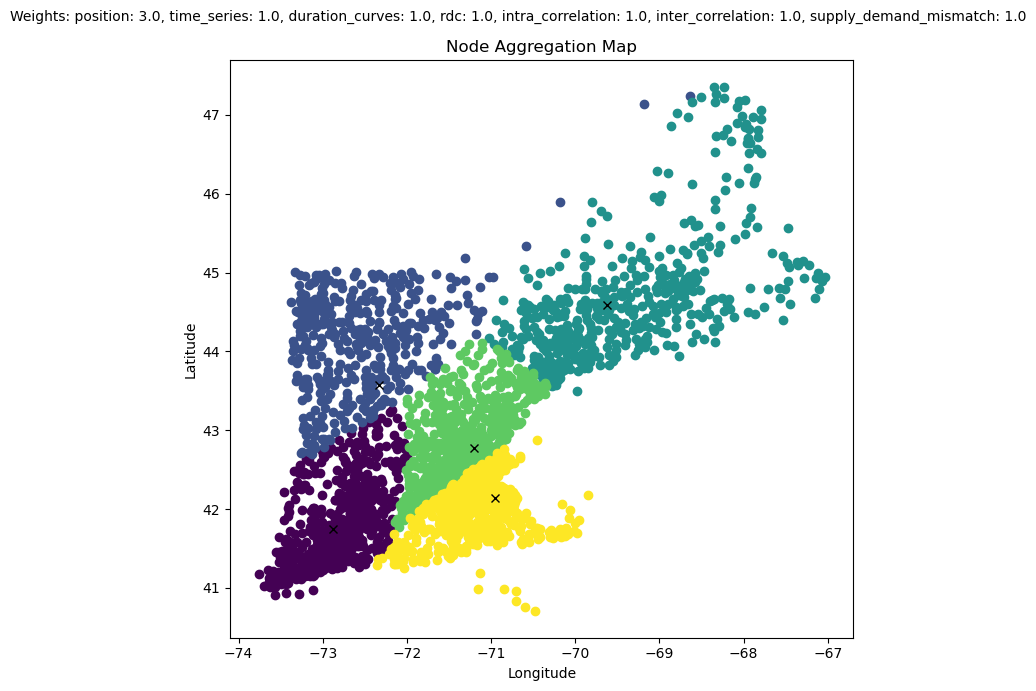

In [35]:
visualizer = Visualization(aggregator)
visualizer.plot_map(aggregation_method='kmedoids')

In [36]:
config.k_representative_days = 5
temp = TemporalAggregation(aggregator, cluster_assignment_dict, spatial_aggregation_method = "kmedoids")

In [37]:
rep_days = temp.aggregate()

Representative days: [114, 136, 172, 246, 295]
